# Import of library

In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, make_scorer, recall_score, precision_recall_curve, auc

In [2]:
#Importing dataframe
working_df=pd.read_csv('data/Modeling/working_df.csv')

In [4]:
working_df.dropna(axis=0,inplace=True)

## Stemming of text comments

In [7]:
#Initialize the Snowball Stemmer
stemmer = SnowballStemmer('english')

#Defining a function to stem a single sentence
def stem_sentence(sentence):
    words = nltk.word_tokenize(sentence)
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

#Applying the function to the text_translated column
working_df['text_translated'] = working_df['text_translated'].apply(stem_sentence)

# Train, test & split of data

In [8]:
#Assigning X and y variables
X=working_df['text_translated']
y=working_df['hateful']

#Splitting the data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1, stratify=y)

# Functions used in evaluation

In [9]:
#Function to calculate precision and recall
def score_summary(cm):
    tn, fp, fn, tp=cm.ravel()
    precision=tp/(tp+fp)
    recall=tp/(tp+fn)
    accuracy=(tp+tn)/(tn+fp+fn+tp)
    print(f'Recall score: {round((recall),5)}')
    print(f'Precision score: {round((precision),5)}')
    print(f'F1 score: {round((2 * (precision * recall) / (precision + recall)),5)}')
    print(f'Accuracy score: {round((accuracy),5)}')

In [10]:
def eval_summary(gs,X_train,y_train):
    
    #Getting the best performing parameters and estimator
    gs_est=gs.best_estimator_
    print(f'Best Estimator :{gs_est}')
    print('\n\n')
   
    #Predictions using test/train dataset
    y_test_pred=gs.predict(X_test)
    y_train_pred=gs.predict(X_train)
    #Generating Confusion matrix
    cm_train=confusion_matrix(y_train, y_train_pred)
    cm=confusion_matrix(y_test, y_test_pred)
    
    #Score summary on train data
    print(f'Score summary on train data')
    print(f'---------------------------')
    score_summary(cm_train)
    print('\n\n')

    #Score summary on test data
    print(f'Score summary on test data')
    print(f'---------------------------')
    score_summary(cm)
    print('\n\n')
    
    #Ploting the confusion matrix
    disp=ConfusionMatrixDisplay(cm, display_labels=['Non-hateful','Hateful'])
    disp.plot()
    plt.title('Confusion Matrix of test data metrics');

# Approach 1A: TF-IDF vectorization + Multinomial Naive Bayes 

## Preprocessing & Vectorizing

Rationale: 
- TF-IDF vectorization is selected for the first approach as it assigns heavier weight to less frequent tokens and less weight to more frequent tokens which might provide a better basis for training a more effective model. Additionally, GridsearchCV will be use for more efficient tuning of hyperparameters which can reduce time to arrive at optimal models.
- It is aware that the dataset is significantly imbalanced (95% are non-hateful) as illustrated in EDA but this model is constructed as a benchmark for further improvements with approaches later on. 

The data will undergo preprocessing with TFIDF vectorizing with:
- the use of standard english stopwords filter
- maximum appearence of a word across 90/95% of all documents
- minimum appearence of a word of at least 2/3 times

## Modeling

Rationale:
- Multinomial Naive Bayes is selected due to its relative speed in training and since TF-IDF vectorizer is used which provides fractional counts of the tokens. Despite the unsatisfied assumption of independent tokens, it ususally still provide decent results.

In [11]:
#Instantiate pipeline 
pipe1A = Pipeline([('tvec', TfidfVectorizer()), ('nb', MultinomialNB())])

In [12]:
#Setting pipe parameters
pipe1A_params={'tvec__stop_words': ['english',None],
                'tvec__min_df': [2, 3],
                'tvec__max_df': [.9, .95],
                'tvec__ngram_range': [(1,1), (1,2)],
                'nb__alpha': np.linspace(1,10,3)}

In [13]:
#Initiating the scoring metric to be on Recall since this is our focus
recall_scorer = make_scorer(recall_score)

In [14]:
#Instantiate Gridsearch
gs1A=GridSearchCV(pipe1A,
                  param_grid=pipe1A_params,
                  cv=5, scoring=recall_scorer)

In [15]:
#Train model
gs1A.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'nb__alpha': array([ 1. ,  5.5, 10. ]),
                         'tvec__max_df': [0.9, 0.95], 'tvec__min_df': [2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': ['english', None]},
             scoring=make_scorer(recall_score))

## Evaluation

Given how the dataset is imbalanced, we will explore other metrics beside accuracy score, specifically:

- Recall **(Higher consideration)** 
    - Measures type 1 error. Since we want to ensure that a hateful comment will be successfully targeted whenever it is present (i.e Minimize false negatives).
- Precision **(Lesser considertion)** How accurate the detected hateful comment predictions are (i.e Minimise false positives)
- F1 score (Balance between Precision and Recall for overall performance)

Best Estimator :Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.9, min_df=3, ngram_range=(1, 2),
                                 stop_words='english')),
                ('nb', MultinomialNB())])



Score summary on train data
---------------------------
Recall score: 0.18149
Precision score: 0.89474
F1 score: 0.30178
Accuracy score: 0.95437



Score summary on test data
---------------------------
Recall score: 0.16844
Precision score: 0.88764
F1 score: 0.28315
Accuracy score: 0.9536





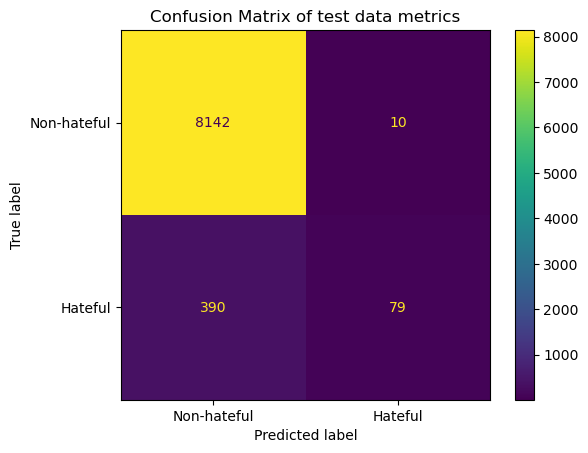

In [16]:
eval_summary(gs1A,X_train,y_train)

Conclusion:
- Very poor Recall and F1 score
    - Recall score (0.16) on test data, significantly far off from targeted 0.75. Poor classifier on hateful comments which might be due to insufficient hateful comments to train the model leading to most comments being classified as non-hateful.
- Slight indication of overfitting from the comparison of Recall score
- High Precision and Accuracy score. This is not appreciated due to:
    - Imbalanced nature of dataset which might attribute to high Accuracy 
    - High volume of data of non-hateful comments which provides a model to detect correctly classify non-hateful comments but does not imply high ability to classify hateful comments correctly


Further action:
- Oversample minority data to acheive balance data



# Approach 1B: Oversampler + TF-IDF vectorizer + Naive Bayes model

## Preprocessing & Vectorizing

Rationale:
- The hyperparameters are kept the same for consistency where the only difference is the resampling of datasets.
- It is choosen to go with oversampling of minority instead of undersampling of majority so as to provide more data(i.e rows) for the data to train on.

Parameters of preprocess and vectorizing:
- TF-IDF vectorizer
    - Same parameters as 1A
- Logistic regression 
    - Ridge 
    - C (1/alpha) = 0.1, 0.5, 1 

In [20]:
#Using imblearn library to draw random samples
from imblearn.over_sampling import RandomOverSampler

#Defining the oversampling objects
oversampler = RandomOverSampler(random_state=0)

#Reshape to fit into the oversampler
X_train_reshaped = X_train.values.reshape(-1, 1)

#New sets of X and y data after oversampling
X_train_ros, y_train_ros = oversampler.fit_resample(X_train_reshaped, y_train)
X_train_ros=pd.Series(X_train_ros.reshape(-1))

## Modeling

In [21]:
#Instantiate pipeline 
pipe1B = Pipeline([('tvec', TfidfVectorizer())
                   , ('nb', MultinomialNB())])

In [22]:
#Setting pipe parameters
pipe1B_params={'tvec__stop_words': ['english',None],
                'tvec__min_df': [2, 3],
                'tvec__max_df': [.9, .95],
                'tvec__ngram_range': [(1,1), (1,2)],
                'nb__alpha': np.linspace(1,10,3)}  

In [23]:
#Instantiate Gridsearch
gs1B=GridSearchCV(pipe1B,
                  param_grid=pipe1B_params,
                  cv=5,scoring=recall_scorer)

In [24]:
#Train model
gs1B.fit(X_train_ros,y_train_ros)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'nb__alpha': array([ 1. ,  5.5, 10. ]),
                         'tvec__max_df': [0.9, 0.95], 'tvec__min_df': [2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': ['english', None]},
             scoring=make_scorer(recall_score))

## Evaluation

Best Estimator :Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.9, min_df=2, ngram_range=(1, 2))),
                ('nb', MultinomialNB())])



Score summary on train data
---------------------------
Recall score: 0.99419
Precision score: 0.94796
F1 score: 0.97052
Accuracy score: 0.96981



Score summary on test data
---------------------------
Recall score: 0.66311
Precision score: 0.34594
F1 score: 0.45468
Accuracy score: 0.91347





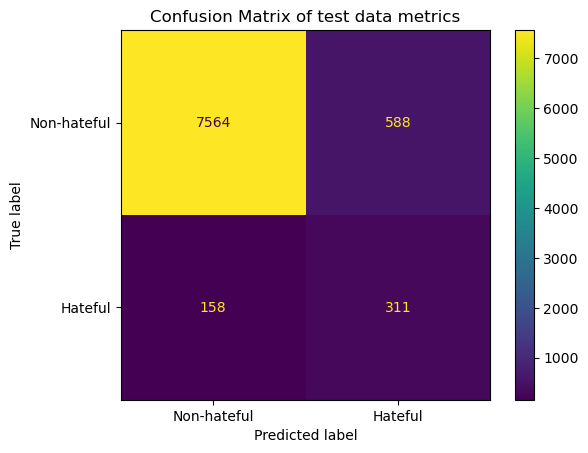

In [28]:
eval_summary(gs1B,X_train_ros,y_train_ros)

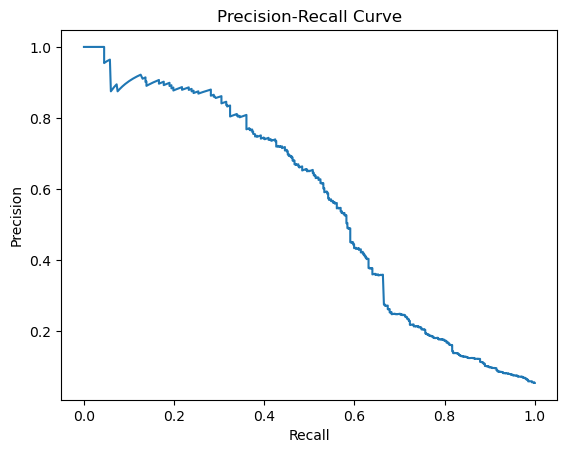

AUC of Precision-Recall Curve: 0.5544116071287492


In [27]:
#Compute precision and recall for different thresholds
y_pred_proba = gs1B.best_estimator_.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

#Plot the PR curve
plt.plot(recall, precision)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

#Computing Area under curve
auc_PR=auc(recall, precision)
print(f'AUC of Precision-Recall Curve: {auc_PR}')

##### Conclusion: 
- Low Recall and Precision score on test data but with improvements
    - Recall score (0.66), Precision score (0.35) and F1 score (0.45), closer to targeted 0.75 for Recall and 0.6 for Precision. With the increase in hateful comments to train on, it has improved vastly on minimising false negatives.
    - Having a balanced train data have shown much improvments on Recall metric thus subsequent approaches will be trained using the balanced data fom oversampling the minority.
<br></br>
- Indication of overfitting from the comparison of Recall score
    - Recall score on test (0.66) is significantly lower than train (0.99)
<br></br>
- AUC of Precision-Recall curve at 0.55
    - Low magnitude of area under the curve implying that the current model have limitation on acheiving good metrics for both Recall and Precision regardless of adjusting decision threshold.


Further action:
- To deal with overfitting and overall improvement on model metrics, further modeling approaches will involve regularisation.



# Approach 2A: Oversampler + TF-IDF vectorizer + Logistic Regression model

## Preprocessing & Vectorizing

Rationale:
- Keeping the consistency of using oversampled minority train data and TF-IDF vectorizer with a limitation on maximum features tokenized in attempt to reduce overfitting.
- Logistic regression model is selected due to its capability of having regularization function to reduce overfitting.

Parameters of preprocess and vectorizing:
- TF-IDF vectorizer
    - Same parameters with addition of maximum features
- Logistic regression 
    - Ridge 
    - C (1/alpha) = 0.1, 0.5, 1 

## Modeling

In [29]:
#Instantiate pipeline 
pipe2A = Pipeline([('tvec', TfidfVectorizer())
                   , ('lr', LogisticRegression())])

In [30]:
#Setting pipe parameters
pipe2A_params={'tvec__stop_words': ['english'],
                'tvec__max_features': [5000,7500,10000],
                'tvec__min_df': [2, 3],
                'tvec__max_df': [.9,.95],
                'tvec__ngram_range': [(1,1), (1,2)],
                'lr__penalty': ['l2'],
                'lr__C': [0.1,0.5,1],
                'lr__solver': ['liblinear'],
                'lr__max_iter': [1000,2000]}

In [31]:
#Instantiate Gridsearch
gs2A=GridSearchCV(pipe2A,
                  param_grid=pipe2A_params,
                  cv=5, scoring=recall_scorer)

In [32]:
#Train model
gs2A.fit(X_train_ros,y_train_ros)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'lr__C': [0.1, 0.5, 1], 'lr__max_iter': [1000, 2000],
                         'lr__penalty': ['l2'], 'lr__solver': ['liblinear'],
                         'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [5000, 7500, 10000],
                         'tvec__min_df': [2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': ['english']},
             scoring=make_scorer(recall_score))

## Evaluation

Best Estimator :Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.9, max_features=10000, min_df=2,
                                 ngram_range=(1, 2), stop_words='english')),
                ('lr',
                 LogisticRegression(C=1, max_iter=1000, solver='liblinear'))])



Score summary on train data
---------------------------
Recall score: 0.99309
Precision score: 0.98384
F1 score: 0.98844
Accuracy score: 0.98839



Score summary on test data
---------------------------
Recall score: 0.77186
Precision score: 0.71542
F1 score: 0.74256
Accuracy score: 0.97089





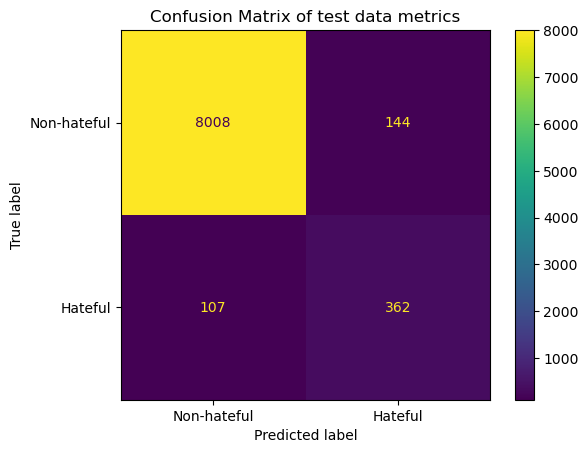

In [33]:
eval_summary(gs2A, X_train_ros, y_train_ros)

Conclusion:
- Further improvement to Recall, Precision and F1 score
    - Recall score(0.77), Precision score(0.72) and F1 score(0.74) within acceptable ranges.
<br></br>
- Indication of overfitting from the comparison of Recall score
    - Recall score on test (0.77) is significantly lower than train (0.99) despite attempts of using ridge regularization the model still overfits. 
<br></br>

Further action:
- Analyse with Precision-Recall curve to find optimal decision threshold in attempt to further fine tune Recall score at accpetable levels of trade-off of Precision.



### Ajusting decision threshold

Rationale:
- Use of Precision-Recall curve to visualise and determine the optimal level of decision threshold that prioritise maximising Recall than Precision


In [36]:
#Compute precision and recall for different thresholds
y_pred_proba = gs2A.best_estimator_.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

After obtaining the Precision and Recall scores across all decision threshold levels, it will be use to compute the optimal level of decision threshold that maximises Recall with minimum acceptable range of trade-off to Precision. Below shows the process of finding the optimal decision threshold with placing more weightage on the prioritised metric, Recall, over Precision.

In [37]:
#Determining weightage and emphasis on Precision VS Recall metric
beta = 1.5
weights = [0.3, 0.7]  

#Calculate F-beta scores for different thresholds
f_beta_scores = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)

#Applying weights to F-beta scores
weighted_scores = weights[0] * recall + weights[1] * f_beta_scores

#Finding the index where maximum weighted score occurs
max_score_index = np.argmax(weighted_scores)

#Finding the threshold, recall, and precision values where maximum weighted score occurs
best_threshold = thresholds[max_score_index]
best_recall = recall[max_score_index]
best_precision = precision[max_score_index]

#Finding the indices of recall and precision where maximum weighted score occurs
recall_index = np.where(recall == best_recall)[0][0]
precision_index = np.where(precision == best_precision)[0][0]

print("Best threshold:", best_threshold)
print("Best recall:", best_recall)
print("Best precision:", best_precision)

Best threshold: 0.410379398230629
Best recall: 0.8123667377398721
Best precision: 0.6523972602739726


The optimal decision threshold is found to be at 0.41 with respective Recall at 0.81 and Precision at 0.65 which is within the acceptable range of metric performance.  

Below illustrates the Precision-Recall curve which plots the trade-off between Precision and Recall across all decision threshold.

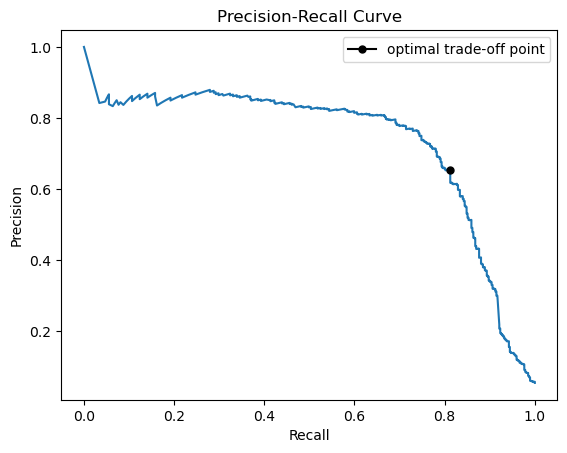

AUC of Precision-Recall Curve: 0.7338932445019035


In [44]:
#Plotting the PR curve
plt.plot(recall, precision)
plt.plot(recall[recall_index], precision[precision_index], marker='o', markersize=5, color="black", label='optimal trade-off point')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

#Computing Area under curve
auc_PR=auc(recall, precision)
print(f'AUC of Precision-Recall Curve: {auc_PR}')

Understanding the optimal threshold to be at 0.41, below shows the metric performance with this adjustment.

In [40]:
#Revising y_pred_proba with new decision threshold
y_pred_newthres = (y_pred_proba >= best_threshold).astype(int)

Score summary after adjusting decision threshold to 0.41
----------------------------------------------------------
Recall score: 0.81237
Precision score: 0.6524
F1 score: 0.72365
Accuracy score: 0.96625





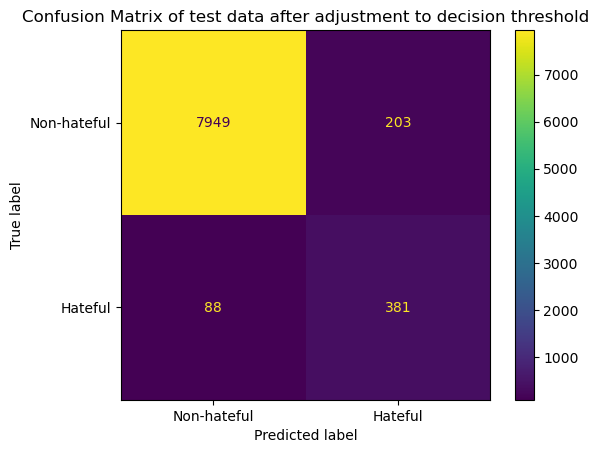

In [41]:
cm_newthres=confusion_matrix(y_test, y_pred_newthres)
print('Score summary after adjusting decision threshold to 0.41')
print('----------------------------------------------------------')
score_summary(cm_newthres)
print('\n\n')
#Ploting the confusion matrix
disp=ConfusionMatrixDisplay(cm_newthres, display_labels=['Non-hateful','Hateful'])
disp.plot()
plt.title('Confusion Matrix of test data after adjustment to decision threshold');

Conclusion:
- Improvement on Recall to 0.81 but at the trade-off of Precision to 0.65. 
- Nonetheless, the AUC of Precision-recall curve (0.73) is higher than the previous approach implying that this model is able to achieve better combination of both Recall and Precision metrics.
- The problem of overfitting still exists.

Further action:
- Exploration of other modeling approaches to reduce overfitting.

# Approach 3: Oversampler + TF-IDF vectorizer + Random Forest

## Preprocessing & Vectorizing

Rationale:
- Keeping the consistency of using oversampled minority train data and TF-IDF vectorizer with a limitation on maximum features tokenized in attempt to reduce overfitting.
- Despite attempting regularization with Logistic regression, there are still indication of overfitting. Random forest classifier will be explore in attempt to achieve satisfactory metrics and also ensure low/no overfitting as there are multiple parameters to explore in dealing with overfitting.

Parameters of preprocess and vectorizing:
- TF-IDF vectorizer
    - Same parameters with addition of maximum features
- Random tree classifier  
    - n_estimators: 100
    - max_depth: 30
    - samples_split: 5
    - samples_leaf: 3


Choice of parameters are selected based on optimal results from behind-the-scenes hyperparameter tuning.

## Modeling

In [49]:
#Instantiate pipeline 
pipe3A = Pipeline([('tvec', TfidfVectorizer())
                   , ('rf', RandomForestClassifier())])

In [46]:
#Setting pipe parameters
pipe3A_params={'tvec__stop_words': ['english'],
                'tvec__max_features': [10000],
                'tvec__min_df': [2, 3],
                'tvec__max_df': [.9,.95],
                'tvec__ngram_range': [(1,1),(1,2)],
                'rf__n_estimators': [100],
                'rf__max_depth': [30],
                'rf__min_samples_split': [5],
                'rf__min_samples_leaf': [3]}

In [47]:
#Instantiate Gridsearch
gs3A=GridSearchCV(pipe3A,
                  param_grid=pipe3A_params,
                  cv=5, scoring=recall_scorer)

In [48]:
#Train model
gs3A.fit(X_train_ros,y_train_ros)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__max_depth': [30], 'rf__min_samples_leaf': [3],
                         'rf__min_samples_split': [5],
                         'rf__n_estimators': [100], 'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [10000], 'tvec__min_df': [2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': ['english']},
             scoring=make_scorer(recall_score))

## Evaluation

Best Estimator :Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.95, max_features=10000, min_df=2,
                                 stop_words='english')),
                ('rf',
                 RandomForestClassifier(max_depth=30, min_samples_leaf=3,
                                        min_samples_split=5))])



Score summary on train data
---------------------------
Recall score: 0.84197
Precision score: 0.96895
F1 score: 0.90101
Accuracy score: 0.90749



Score summary on test data
---------------------------
Recall score: 0.8145
Precision score: 0.63245
F1 score: 0.71202
Accuracy score: 0.96416





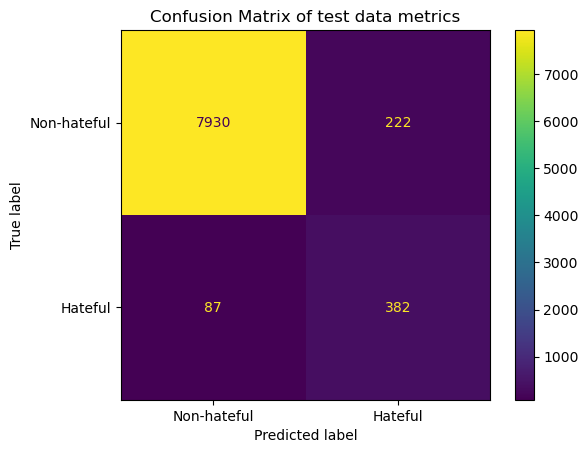

In [50]:
eval_summary(gs3A, X_train_ros, y_train_ros)

Similarly, the optimal level of decision threshold is computed to maximise Recall with minimisation to the trade-off of Precision.

In [51]:
#Compute precision and recall for different thresholds
y_pred_proba = gs3A.best_estimator_.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

#Determining weightage and emphasis on Precision VS Recall metric
beta = 1.5
weights = [0.3, 0.7]  

#Calculate F-beta scores for different thresholds
f_beta_scores = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)

#Applying weights to F-beta scores
weighted_scores = weights[0] * recall + weights[1] * f_beta_scores

#Finding the index where maximum weighted score occurs
max_score_index = np.argmax(weighted_scores)

#Finding the threshold, recall, and precision values where maximum weighted score occurs
best_threshold = thresholds[max_score_index]
best_recall = recall[max_score_index]
best_precision = precision[max_score_index]

#Finding the indices of recall and precision where maximum weighted score occurs
recall_index = np.where(recall == best_recall)[0][0]
precision_index = np.where(precision == best_precision)[0][0]

print("Best threshold:", best_threshold)
print("Best recall:", best_recall)
print("Best precision:", best_precision)

Best threshold: 0.49909856235600847
Best recall: 0.8208955223880597
Best precision: 0.6332236842105263


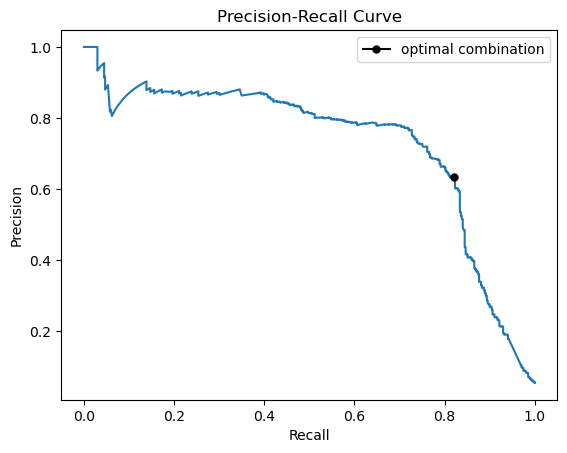

AUC of Precision-Recall Curve: 0.7293411964012895


In [52]:
#Plotting the PR curve
plt.plot(recall, precision)
plt.plot(recall[recall_index], precision[precision_index], marker='o', markersize=5, color="black", label='optimal combination')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

#Computing Area under curve
auc_PR=auc(recall, precision)
print(f'AUC of Precision-Recall Curve: {auc_PR}')

Conclusion:
- Improvement on Recall and reduced overfitting to acceptable range
    - Recall score have improved to 0.81 on test data and 0.84 on train data.
- Poorer Precision score and overfitting
    - Precision score of 0.63 on test data and overfits with 0.97 on train data.
- Slight improvment of metrics by adjusting decision threshold
    - AUC of Precision-Recall curve (0.73) is relatively equal to the previous approach and its optimal decision threshold is close to the default of 0.5 (recommended at 0.49) with slightly better metric of 0.82(Recall) and 0.63(Precision)

# Conclusion/Future works

Summary of approaches:

|Approach|Description on best parameters|Metrics|Conclusion|
|-|-|-|-|
|1A|TF-IDF Vectorization<ul><li>english stopwords filter</li><li>max document frequency:90%</li><li>min document frequency:3times</li><li>uni/bi-gram</li></ul><br>Naive Bayes classification|Recall<ul><li>0.1557(test)</li><li>0.1829(train)</li></ul><br>Precision<ul><li>0.8902(test)<li>0.8862(train)</li></ul>|Poor metrics likely due to imbalanced data|
|1B|TF-IDF Vectorization<ul><li>english stopwords filter</li><li>max document frequency:90%</li><li>min document frequency:2times</li><li>uni/bi-gram</li></ul>Naive Bayes classification<br><br>Oversampler<ul><li>minority data(hateful comments)</li></ul>|Recall<ul><li>0.6461(test)</li><li>0.9929(train)</li></ul><br>Precision<ul><li>0.3732(test)</li><li>0.9563(train)</li></ul>AUC-PR: 0.5171|Overfitting model with low scores|
|2A|TF-IDF Vectorization<ul><li>english stopwords filter</li><li>max document frequency:90%</li><li>min document frequency:2times</li><li>uni/bi-gram</li><li>max features: 10000</li></ul><br>Logistic Regression<ul><li>C:1</li><li>solver:'liblinear'</li></ul><br><br>Oversampler<li>minority data(hateful comments)|Recall<ul><li>0.7719(test)<li>0.9931(train)</li></ul><br>Precision<ul><li>0.7168(test)<li>0.9840(train)</li></ul><br>AUC-PR: 0.7272|Overfitting model with improved scores|
|2A*|Same parameters as 2A with adjusment to decision threshold to 0.4483|Recall<ul><li>0.7847(test)</li></ul><br>Precision<ul><li>0.6853(test)</li></ul>|Overfitting model with further improvment to Recall with the tradeoff of Precision|
|3|TF-IDF Vectorization<li>english stopwords filter<li>max document frequency:90%<li>min document frequency:2times<li>uni-gram<li>max features: 10000</li><br>Random Forest classifier<li>C:1<li>solver:'liblinear'<br>Oversampler<li>minority data(hateful comments)|Recall<ul><li>0.8017(test)<li>0.8497(train)</ul><br>Precision<ul><li>0.9649(test)<li>0.6193(train)</li></ul><br>AUC-PR: 0.7377|Improved scores on Recall and overfitting has significantly reduced|


Approach 3 will be the model selected for the classifier given the metric in focus (Recall) have been satisfied (>0.75 Recall score), its secondary objective (>0.6 Precision score) was slightly underacheived implying that the model will likely have more cases of False positives than False negatives. 

It is also noted that there is overfitting based on the Precision metric (test: 0.596 & train: 0.964) which implies that the model aggressive in classifying comments to be hateful.

However, the classification model is still useful to effectively identify potential hateful comments which can act as a primary filter for the user before a second in-person check can take place which saves time and resources for the user. For comments that are found to have non-hateful context will be approve for publishing. 

## Insights on features

In [52]:
#Finding features that has most impact on determining if a comment is hateful

# Retrieve the feature importances by Gini impurity 
rf = gs3A.best_estimator_.named_steps['rf']
feature_importances = rf.feature_importances_

# Getting the feature names 
tvec = gs3A.best_estimator_.named_steps['tvec']
feature_names = tvec.get_feature_names_out()

# Creating a DataFrame to display the feature importances
fi_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
fi_df.sort_values(by='importance', ascending=False, inplace=True)
fi_df.head(10)

,feature,importance
1825,fuck,0.190051
3876,shit,0.097344
664,bitch,0.041548
468,ass,0.040599
4189,suck,0.038873
4170,stupid,0.028584
2541,lasagna,0.027291
2226,idiot,0.021242
4401,trash,0.021193
2661,logan,0.017545


Conclusion:
- The features returned are based on Gini impurity, sorted by highest to lowest. Words with higher Gini impurity have more composition in the leaf nodes implying that it is more commonly found in the classification of hateful comments.
- The purpose of understanding/identifying which words are more commonly used enables officials to know the sentiment of the platform users and thus enforce relevant policies for society cohesiveness. 
    - For example, if a high importance word describes a certain ethnic/racial group in society, the officials can raise public awareness or implement public education programs targeted to promote tolerance

## Future works

- Gather more balanced data (i.e more hateful comments) instead of using Oversampler to balance data since the model will be trained on similar tokens that posed hateful context which might not be reliable in classifying unseen data.

- Gather wider range of context of videos for better performance on general comments. Since the current model is trained on videos that are more popular among the younger generation, the slangs/lingo use by the population can be different thus affecting the classification results on a comment from a different demographic.

- Removal of the common tokens that appear the most in hateful/non-hateful comments to reduce ambiguity for the model in classifying. This would likely to improve both Precision and Recall scores as it minimizes both False positives and False negatives which will acheive our initial goal of having an auto-classifier without the need of manual filtering.

- The project is targed to detect hateful comments based on the determined weightage of attributes where it emphasises on Toxicity and less on other attributes. This can be adjusted according to the user's objective.
    - For example, to detect for possible suicidal/troubled youths or radicalized potential terrorists by adjusting higher weightage on the Threat attribute. To detect for individuals that attempts to disrupt racial harmony through racist remarks, the user can adjust higher weightage on the Identity_attack attribute.